In [1]:
import os
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models , layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
dir= './mini_speech_commands'
sr= 16000

In [3]:
def audio_to_mfcc(auido_path,sr=sr):
    y,_ = librosa.load(auido_path,sr=sr)
    if len(y) < sr:
        padding = sr - len(y)
        y = np.pad(y, (0, padding), mode='constant')
    else:
        y = y[:sr]
    mfcc = librosa.feature.mfcc(y=y,sr=sr,n_mfcc=20)
    mfcc = (mfcc - np.mean(mfcc))/np.std(mfcc)
    return mfcc

In [4]:
def load_dataset(dir):
    mfccs,labels=[],[]

    for label in os.listdir(dir):
        label_dir = os.path.join(dir,label)
        if not os.path.isdir(label_dir):
            continue
        print(f'loading label : {label}')

        for file in tqdm(os.listdir(label_dir)):
            file_path = os.path.join(label_dir,file)
            if file_path.endswith(".wav"):
                mfcc = audio_to_mfcc(file_path)
                mfccs.append(mfcc)
                labels.append(label)
    return np.array(mfccs), np.array(labels)

In [5]:
mfccs , labels = load_dataset(dir)

loading label : down


100%|██████████| 1000/1000 [00:05<00:00, 199.01it/s]


loading label : go


100%|██████████| 1000/1000 [00:03<00:00, 305.01it/s]


loading label : left


100%|██████████| 1000/1000 [00:03<00:00, 318.67it/s]


loading label : right


100%|██████████| 1000/1000 [00:03<00:00, 328.33it/s]


loading label : up


100%|██████████| 1000/1000 [00:03<00:00, 320.02it/s]


In [6]:
print(mfccs.shape)

(5000, 20, 32)


In [7]:
def plot_mfcc(mfcc,label):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'mfcc of {label}')
    plt.tight_layout()
    plt.show()

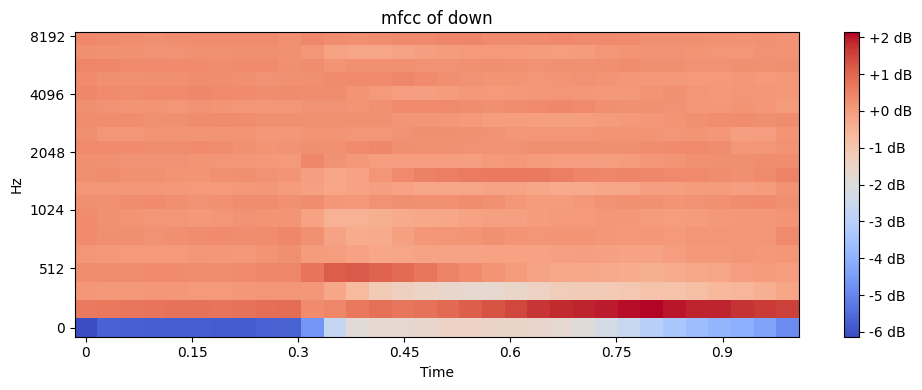

In [8]:
plot_mfcc(mfccs[1],labels[1])

In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [10]:
encoded_labels.shape

(5000,)

In [ ]:
rezised_mfccs = np.array([cv2.resize(s, (128,128)) for s in mfccs])
rezised_mfccs = rezised_mfccs[...,np.newaxis]

In [12]:
rezised_mfccs.shape

(5000, 128, 128, 1)

In [13]:
X_train , X_test , y_train, y_test = train_test_split(rezised_mfccs,
                                                      encoded_labels,
                                                      test_size=0.2,
                                                      random_state=42)

In [40]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01),input_shape=(128,128,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(5,activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [41]:
model = create_model()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,709 (12.61 MB)

 Trainable params: 3,304,709 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stopping_callback = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [43]:
history = model.fit(
    X_train,y_train,
    epochs = 20,
    batch_size = 64,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.2765 - loss: 1.6044 - val_accuracy: 0.6175 - val_loss: 1.1095
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - accuracy: 0.5896 - loss: 1.1092 - val_accuracy: 0.6950 - val_loss: 0.8709
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 288ms/step - accuracy: 0.7155 - loss: 0.8572 - val_accuracy: 0.7400 - val_loss: 0.7745
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - accuracy: 0.7377 - loss: 0.7265 - val_accuracy: 0.7892 - val_loss: 0.6473
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.8000 - loss: 0.5685 - val_accuracy: 0.8150 - val_loss: 0.5788
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.8212 - loss: 0.4959 - val_accuracy: 0.8125 - val_loss: 0.5614
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.8646 - loss: 0.3942 - val_accuracy: 0.8317 - val_loss: 0.5334
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.8808 - loss: 0.3564 - val_accu

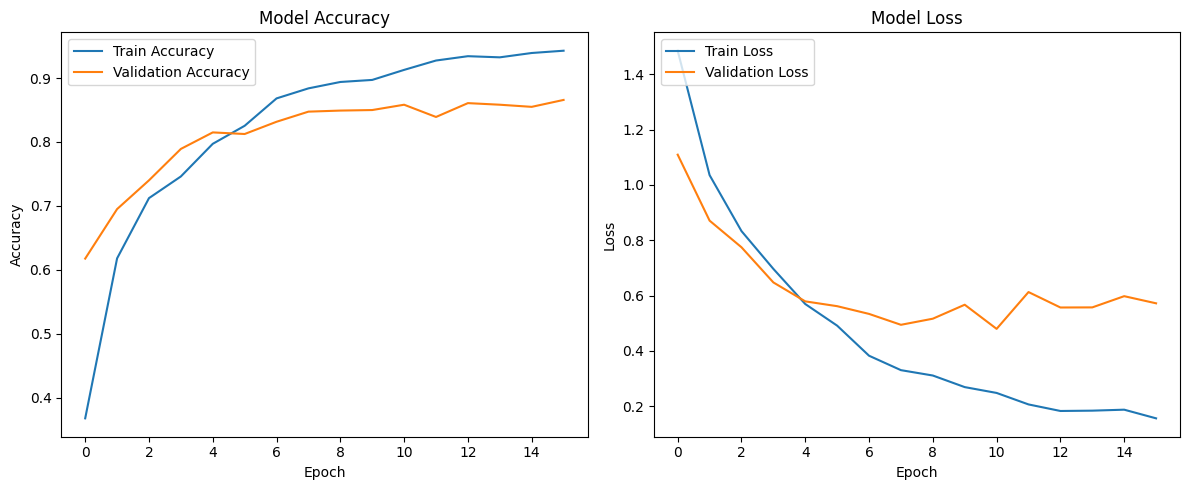

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [45]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8669 - loss: 0.4527
Test Loss: 0.4550, Test Accuracy: 0.8650


In [46]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


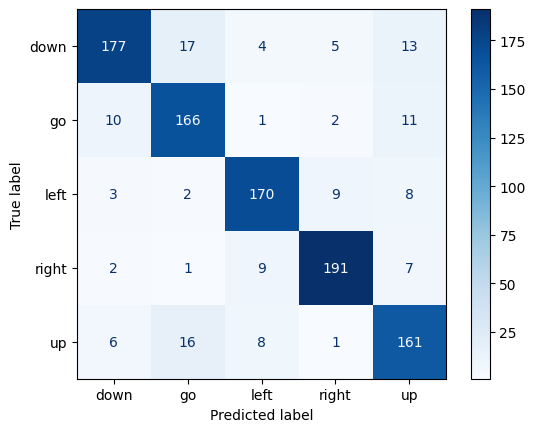

In [47]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [48]:
model.save('model4.h5')